# Washington State Housing Price Dataset

**Group 3:** Benjamin Lacount, Jose Tuozzo Izaguirre, Justin Sobieski, and Brandon Matias

Below is our dataset prior to any changes being made.

In [82]:
import pandas as pd

data_df = pd.read_csv('/content/Raw_Housing_Prices3.csv')
display(data_df.head())

,ID,Date House was Sold,Sale Price,No of Bedrooms,No of Bathrooms,Flat Area (in Sqft),Lot Area (in Sqft),No of Floors,Waterfront View,No of Times Visited,...,Overall Grade,Area of the House from Basement (in Sqft),Basement Area (in Sqft),Age of House (in Years),Renovated Year,Zipcode,Latitude,Longitude,Living Area after Renovation (in Sqft),Lot Area after Renovation (in Sqft)
0,7129300520,14 October 2017,221900.0,3,1.00,1180.0,5650.0,1.0,No,NaN,...,7,1180.0,0,63,0,98178.0,47.5112,-122.257,1340.0,5650
1,6414100192,14 December 2017,538000.0,3,2.25,2570.0,7242.0,2.0,No,NaN,...,7,2170.0,400,67,1991,98125.0,47.7210,-122.319,1690.0,7639
2,5631500400,15 February 2016,180000.0,2,1.00,770.0,10000.0,1.0,No,NaN,...,6,770.0,0,85,0,98028.0,47.7379,-122.233,2720.0,8062
3,2487200875,14 December 2017,604000.0,4,3.00,1960.0,5000.0,1.0,No,NaN,...,7,1050.0,910,53,0,98136.0,47.5208,-122.393,1360.0,5000
4,1954400510,15 February 2016,510000.0,3,2.00,1680.0,8080.0,1.0,No,NaN,...,8,1680.0,0,31,0,98074.0,47.6168,-122.045,1800.0,7503


# Removing Null Values and Weightless Columns:

Below we begin the data cleaning process by identifying and removing any empty or null values in our dataset.

In [83]:
print("\nData types:")
data_df.info()

print("\nMissing values:")
missing_train = data_df.isnull().sum()
print(missing_train[missing_train > 0])


Data types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21609 entries, 0 to 21608
Data columns (total 21 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   ID                                         21609 non-null  int64  
 1   Date House was Sold                        21609 non-null  object 
 2   Sale Price                                 21609 non-null  float64
 3   No of Bedrooms                             21609 non-null  int64  
 4   No of Bathrooms                            21609 non-null  float64
 5   Flat Area (in Sqft)                        21609 non-null  float64
 6   Lot Area (in Sqft)                         21609 non-null  float64
 7   No of Floors                               21609 non-null  float64
 8   Waterfront View                            21609 non-null  object 
 9   No of Times Visited                        2124 non-null   object 
 10  Condition

In the next 2 sections, we identified and removed columns in the dataset that we determined had little relevance to what we wanted our model to predict later on. We dropped these columns and rescanned again for any missing values.

In [84]:
missing_train_percentage = (data_df.isnull().sum() / len(data_df)) * 100
high_missing_cols_train = missing_train_percentage[missing_train_percentage > 30].index

# Columns to be removed as requested by the user.
cols_to_drop = ['No of Times Visited', 'Waterfront View',  'Living Area after Renovation (in Sqft)', 'Area of the House from Basement (in Sqft)', 'Renovated Year', 'Date House was Sold', 'Overall Grade', 'Lot Area after Renovation (in Sqft)']

# Combine the list of columns to drop.
all_cols_to_drop = list(high_missing_cols_train) + cols_to_drop

# Drop columns only if they exist in the DataFrame
cols_to_actually_drop = [col for col in all_cols_to_drop if col in data_df.columns]
data_df = data_df.drop(columns=cols_to_actually_drop)

print("Columns dropped:", cols_to_actually_drop)

Columns dropped: ['No of Times Visited', 'No of Times Visited', 'Waterfront View', 'Living Area after Renovation (in Sqft)', 'Area of the House from Basement (in Sqft)', 'Renovated Year', 'Date House was Sold', 'Overall Grade', 'Lot Area after Renovation (in Sqft)']


In [85]:
numerical_cols = data_df.select_dtypes(include=['int64', 'float64']).columns
for col in numerical_cols:
    if data_df[col].isnull().any():
        data_df[col] = data_df[col].fillna(data_df[col].mean())


categorical_cols = data_df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if data_df[col].isnull().any():
        data_df[col] = data_df[col].fillna(data_df[col].mode()[0])


print("Missing values after filling:")
print(data_df.isnull().sum()[data_df.isnull().sum() > 0])

Missing values after filling:
Series([], dtype: int64)




---



# Feature Engineering:

The features below were selected because they are intuitively related to house valuation, are expected to have a strong correlation with the target variable, and offer a more compact and potentially less overfitting-prone representation of location and value density

The 'price_per_sqft' feature was engineered to provide a standardized metric for comparing the value of houses regardless of their size. This feature was calculated by dividing the 'Sale Price' of each property by its 'Flat Area (in Sqft)'. This calculation provides a per-unit area value, which can be a strong indicator of market value and allows for a more equitable comparison between properties of different sizes.

The 'LocationQuality' feature was created to capture a more refined representation of a property's location beyond just its zipcode, latitude, and longitude. The process involved first calculating the average sale price for each unique zipcode in the dataset using the groupby() method on the 'Zipcode' column and applying the mean() aggregation to the 'Sale Price'. The transform('mean') function was used to broadcast this average back to each row belonging to that zipcode, ensuring the resulting Series has the same index as the original DataFrame. This average zipcode price serves as a proxy for the general desirability and value of that neighborhood. This average zipcode price was then combined with the property's specific Latitude and Longitude coordinates by summing these three values. The rationale behind this combination is to create a composite feature that incorporates both the general neighborhood value (from the average zipcode price) and the precise geographical position, potentially capturing micro-market variations within a zipcode.


Below shows how we incorporated Feature Engineering into our dataset:

In [86]:
# Calculate the average sale price for each zipcode in the training data.
zipcode_avg_price = data_df.groupby('Zipcode')['Sale Price'].transform('mean')

# Create the 'LocationQuality' feature in the training DataFrame by combining zipcode average price, latitude, and longitude.
# This creates a composite feature that incorporates both neighborhood value and specific location.
data_df['LocationQuality'] = zipcode_avg_price + data_df['Latitude'] + data_df['Longitude']

# Create 'price per sqft' feature
data_df['price_per_sqft'] = data_df['Sale Price'] / data_df['Flat Area (in Sqft)']

# Print a header and display the head of the new features in the training DataFrame to verify their creation.
print("New features created in data_df:")
display(data_df[['Zipcode', 'Latitude', 'Longitude', 'LocationQuality','price_per_sqft']].head())

New features created in data_df:


,Zipcode,Latitude,Longitude,LocationQuality,price_per_sqft
0,98178.0,47.5112,-122.257,308360.815269,188.050847
1,98125.0,47.7210,-122.319,462255.806878,209.338521
2,98028.0,47.7379,-122.233,460750.593239,233.766234
3,98136.0,47.5208,-122.393,540391.177230,308.163265
4,98074.0,47.6168,-122.045,666513.773614,303.571429


To make our new variable 'LocationQuality' more understandable to the user, we converted the weight of the numbers into a letter grade system for better transparency and readability.

In [87]:
import numpy as np

# Round the 'LocationQuality' values to the nearest whole number
data_df['LocationQuality_rounded'] = data_df['LocationQuality'].round()

# Define the bins and labels for the letter grades
# We will create 5 bins to represent grades from F, D, C, B, A
# The bins are determined based on the min and max rounded LocationQuality values
min_rounded = data_df['LocationQuality_rounded'].min()
max_rounded = data_df['LocationQuality_rounded'].max()

# Create bins with equal intervals (5 bins for F, D, C, B, A)
bins = np.linspace(min_rounded, max_rounded, 6)

# Define the labels for the bins (F, D, C, B, A)
labels = ['F', 'D', 'C', 'B', 'A']

# Create the 'LocationQuality_Grade' column by assigning a letter grade based on the bins
data_df['LocationQuality_Grade'] = pd.cut(data_df['LocationQuality_rounded'], bins=bins, labels=labels, include_lowest=True)

# Display the head of the new columns and the value counts of the grades
print("Original and rounded LocationQuality with assigned grades:")
display(data_df[['LocationQuality', 'LocationQuality_rounded', 'LocationQuality_Grade']].head())

print("\nValue counts for LocationQuality_Grade:")
display(data_df['LocationQuality_Grade'].value_counts())

Original and rounded LocationQuality with assigned grades:


,LocationQuality,LocationQuality_rounded,LocationQuality_Grade
0,308360.815269,308361.0,F
1,462255.806878,462256.0,D
2,460750.593239,460751.0,D
3,540391.177230,540391.0,D
4,666513.773614,666514.0,C



Value counts for LocationQuality_Grade:


,count
LocationQuality_Grade,
D,7311
F,6747
C,4981
B,1921
A,649




---



# Scaling and Normalization:

# Why Transform Data?
Housing features like 'price_per_sqft' and 'Sale_Price' which can fluctuate significantly in this dataset will not be distributed evenly or fairly so with tools like Scaling and Normailzation, we can equalize the range of the dataset to btter represent lower-range vales and adjust the shape distribution to prevent right-skewness.

Below is how we applied these techniques to our dataset.

In [88]:
# === Scaling & Normalization ===
# Name: José

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Use the data_df which has been cleaned and engineered
df = data_df.copy()

# 1️⃣ Select numeric columns
# Exclude 'ID' and 'Sale Price' (target variable) and the newly created LocationQuality features for now
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cols_to_exclude = ['ID', 'Sale Price', 'LocationQuality', 'LocationQuality_rounded']
numeric_cols = [col for col in numeric_cols if col not in cols_to_exclude]

if not numeric_cols:
    raise ValueError("No numeric columns found for scaling/normalization after exclusion.")
print("Numeric columns to scale/normalize:", numeric_cols)
print("The skewed columns are: ", skewed_cols)
# 2️⃣ Min-Max Scaling to [0,1]
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[numeric_cols] = scaler.fit_transform(df[numeric_cols])


# 3️⃣ Log Normalization (handle non-positive values)
# Apply log normalization to potentially skewed features like area and lot sizes
# Let's select relevant skewed columns based on common housing data patterns and the previous head display
skewed_cols = ['Flat Area (in Sqft)', 'Lot Area (in Sqft)', 'Basement Area (in Sqft)']

# Ensure selected columns exist in the DataFrame and are numeric
skewed_cols = [col for col in skewed_cols if col in numeric_cols]

df_normalized = df_scaled.copy() # Start from scaled data for combined effect if desired, or use original df. Let's use original df for pure log norm comparison

# Apply log1p which is log(1+x) to handle zero values
for col in skewed_cols:
    df_normalized[col] = np.log1p(df[col])


# 4️⃣ Display results for a few scaled/normalized columns
print("\n✅ Scaled and Log Normalized Data Preview (sample of columns):")

display(df_scaled[numeric_cols].head())
display(df_normalized[skewed_cols].head())


Numeric columns to scale/normalize: ['No of Bedrooms', 'No of Bathrooms', 'Flat Area (in Sqft)', 'Lot Area (in Sqft)', 'No of Floors', 'Basement Area (in Sqft)', 'Age of House (in Years)', 'Zipcode', 'Latitude', 'Longitude', 'price_per_sqft']
The skewed columns are:  ['Flat Area (in Sqft)', 'Lot Area (in Sqft)', 'Basement Area (in Sqft)']

✅ Scaled and Log Normalized Data Preview (sample of columns):


,No of Bedrooms,No of Bathrooms,Flat Area (in Sqft),Lot Area (in Sqft),No of Floors,Basement Area (in Sqft),Age of House (in Years),Zipcode,Latitude,Longitude,price_per_sqft
0,0.090909,0.12500,0.067170,0.003108,0.0,0.000000,0.521739,0.893939,0.571498,0.217608,0.143971
1,0.090909,0.28125,0.172075,0.004072,0.4,0.082988,0.556522,0.626263,0.908959,0.166113,0.173264
2,0.060606,0.12500,0.036226,0.005743,0.0,0.000000,0.713043,0.136364,0.936143,0.237542,0.206878
3,0.121212,0.37500,0.126038,0.002714,0.0,0.188797,0.434783,0.681818,0.586939,0.104651,0.309253
4,0.090909,0.25000,0.104906,0.004579,0.0,0.000000,0.243478,0.368687,0.741354,0.393688,0.302934


,Flat Area (in Sqft),Lot Area (in Sqft),Basement Area (in Sqft)
0,7.074117,8.639588,0.000000
1,7.852050,8.887791,5.993961
2,6.647688,9.210440,0.000000
3,7.581210,8.517393,6.814543
4,7.427144,8.997271,0.000000


Distrubtion before scaling and normalization:

Visualizing distributions of selected original numerical features:


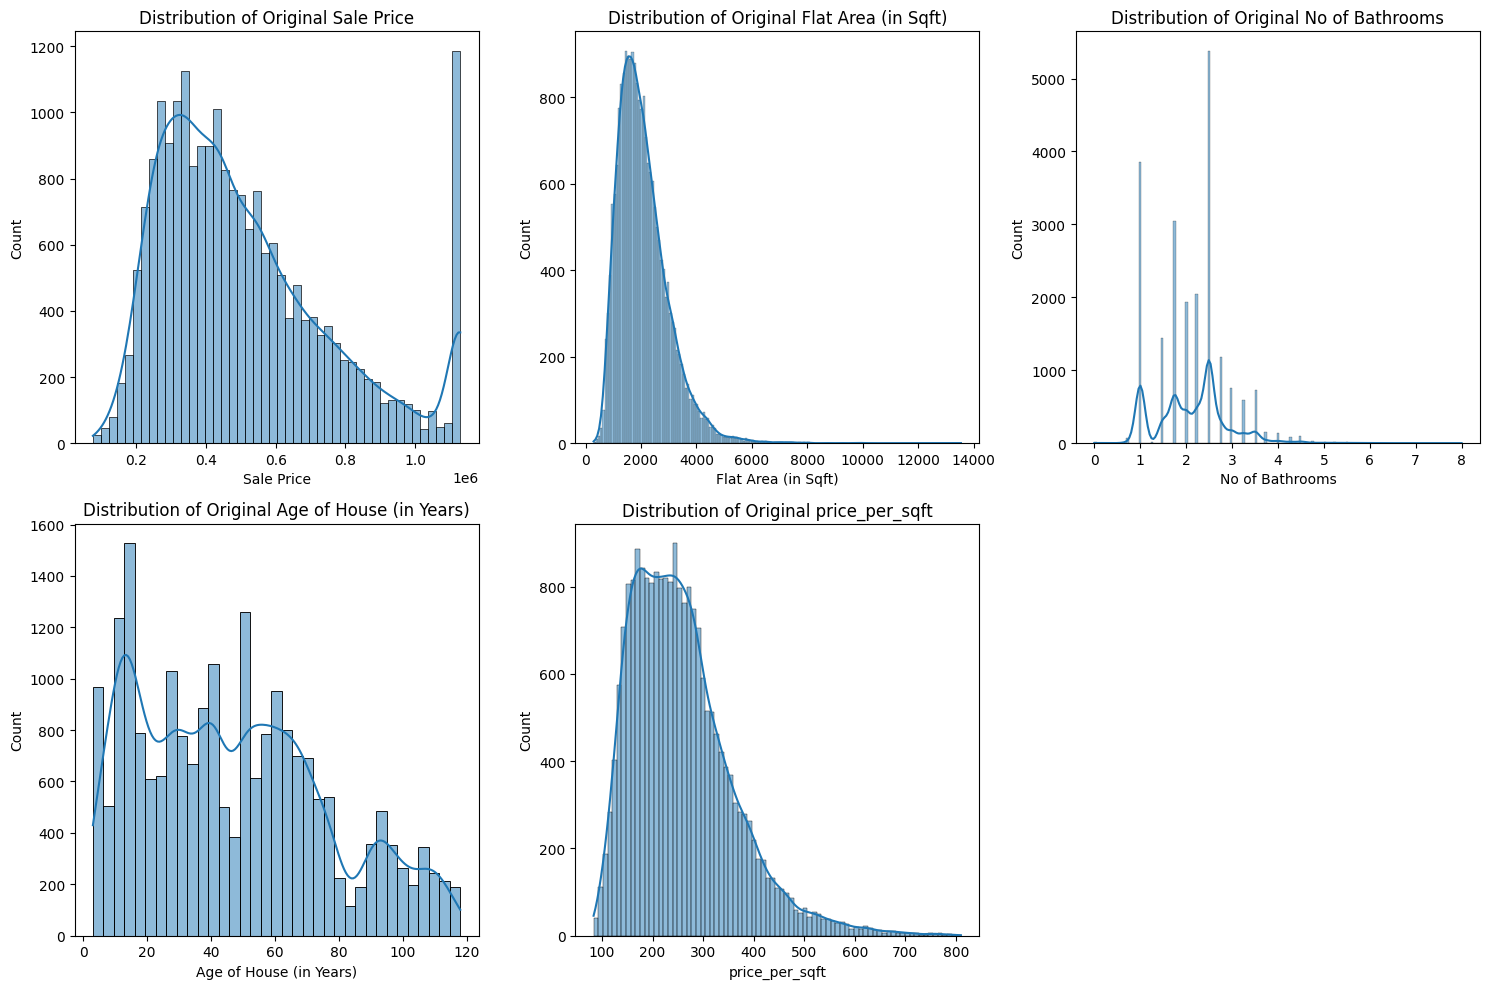

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select the same key numerical columns for visualization from the original data_df
original_cols_to_visualize = ['Sale Price', 'Flat Area (in Sqft)', 'No of Bathrooms', 'Age of House (in Years)', 'price_per_sqft']

# Ensure selected columns exist in the DataFrame
original_cols_to_visualize = [col for col in original_cols_to_visualize if col in data_df.columns]

if original_cols_to_visualize:
    print("Visualizing distributions of selected original numerical features:")
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(original_cols_to_visualize):
        plt.subplot(2, 3, i + 1)
        sns.histplot(data_df[col], kde=True)
        plt.title(f'Distribution of Original {col}')
    plt.tight_layout()
    plt.show()
else:
    print("No original columns available for visualization.")

Distribution after scaling and normalization:

Visualizing distributions of selected scaled numerical features:


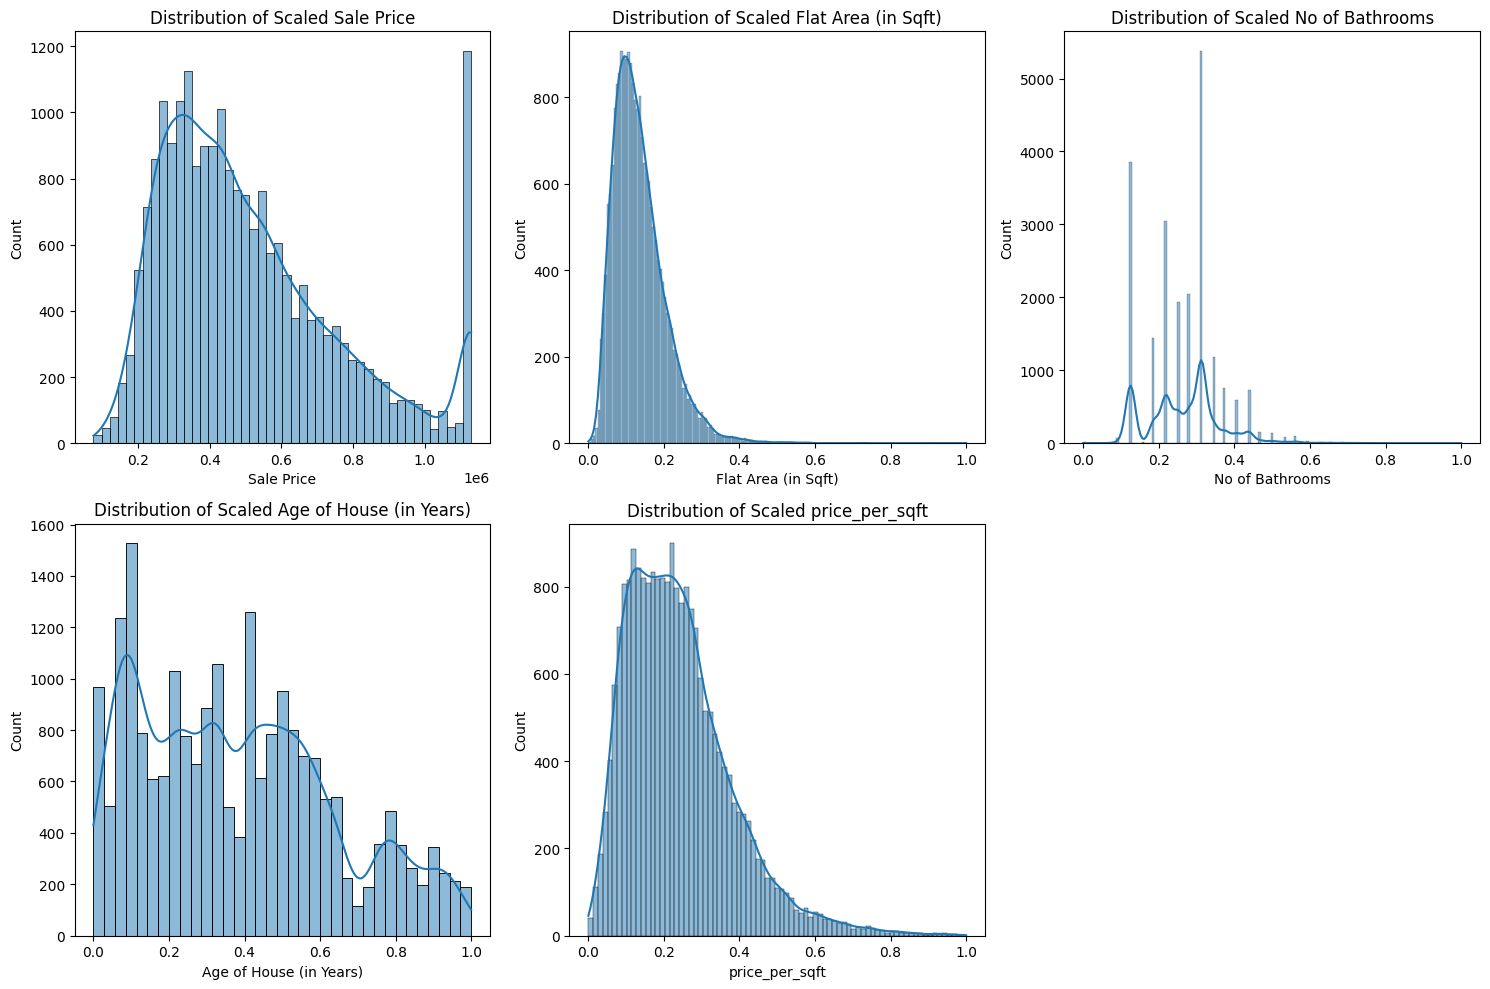

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select a few key scaled numerical columns for visualization
scaled_cols_to_visualize = ['Sale Price', 'Flat Area (in Sqft)', 'No of Bathrooms', 'Age of House (in Years)', 'price_per_sqft']

# Ensure selected columns exist in the DataFrame
scaled_cols_to_visualize = [col for col in scaled_cols_to_visualize if col in df_scaled.columns]

if scaled_cols_to_visualize:
    print("Visualizing distributions of selected scaled numerical features:")
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(scaled_cols_to_visualize):
        plt.subplot(2, 3, i + 1)
        sns.histplot(df_scaled[col], kde=True)
        plt.title(f'Distribution of Scaled {col}')
    plt.tight_layout()
    plt.show()
else:
    print("No scaled columns available for visualization.")



---



# One-Hot and Ordinal Encoding:

# Why Encoding Matters in Housing Data
Machine learning models require numerical input, but real-world housing datasets contain categorical features — like zipcode, condition, or grade — that describe qualities or categories rather than raw numbers.
Encoding converts these text-based or discrete features into numerical form so that algorithms can interpret them correctly.

Without proper encoding, models may misinterpret categories as having unintended numerical meaning (for example, thinking that zipcode 98102 > zipcode 77005).

Two Main Encoding Techniques
One-Hot Encoding (Nominal Data)
Ordinal Encoding (Ordered Data)

1) **One-Hot Encoding** (Nominal / Unordered Features)
This technique is used when categories have no natural order.
Each unique category becomes a separate binary column with values 0 or 1.

Example: zipcode

zipcode: zipcode_98101 vs zipcode_98102
+ 98101: 1	0    
The 1 represents the confirmation that this particular house is indeed located in the zipcode 98101.
+ 98102: 0	1  
The 0 represents the confirmation that this particular house is not located in the zipcode 98101.

  Here, each new column indicates whether a record belongs to that specific zip code (1) or not (0).
  This prevents the model from assuming one zip code is “greater” than another — since zip codes are identifiers, not numeric scales.




---


    



2) **Ordinal Encoding** (Ordered / Ranked Features)
Used when categories have an intrinsic order or hierarchy.
You assign each category a rank-based numeric value that preserves its order.

    **Example:** condition or grade

    Condition	encoded_value

    **Bad**	= 0

    **Okay**	= 1

    **Fair**	= 2

    **Good**	= 3

    **Excellent**	= 4

    Now, the model recognizes that Excellent > Good > Fair > Poor — reflecting an increasing quality scale.
    This maintains ordinal relationships without inflating the dataset size.



In [91]:
# === Encoding Categorical Data ===
# Name: José

import pandas as pd
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

# Use the data_df which has been cleaned and engineered
df = data_df.copy()

# 1️⃣ Identify categorical columns
# Include the newly created 'LocationQuality_Grade' and exclude 'Date House was Sold'
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
cat_cols = [col for col in cat_cols if col not in ['Date House was Sold']] # Exclude the date column
print("Categorical columns:", cat_cols)

# 2️⃣ Define which are ordinal (ordered) and which are nominal (unordered)
# Modify these lists according to your dataset
# Include 'LocationQuality_Grade' as an ordinal feature
ordinal_features = ['Condition of the House', 'LocationQuality_Grade']          # ordered features
nominal_features = []

# 3️⃣ --- Ordinal Encoding ---
# Define a possible ranking for condition/grade (adjust based on your dataset)
# Define the order for 'Condition of the House' and 'LocationQuality_Grade'
ordinal_mapping = {
    'Condition of the House': ['Bad', 'Okay', 'Fair', 'Good', 'Excellent'],
    'LocationQuality_Grade': ['F', 'D', 'C', 'B', 'A']
}

# Create a list of the category lists in the correct order for OrdinalEncoder
categories_for_encoder = [ordinal_mapping[col] for col in ordinal_features]

# Apply ordinal encoding
enc = OrdinalEncoder(categories=categories_for_encoder)
df[ordinal_features] = enc.fit_transform(df[ordinal_features])

print(f"Ordinal encoded: {ordinal_features}")


# 4️⃣ --- One-Hot Encoding ---
# Select only nominal columns that exist in the dataset and are in cat_cols
nominal_to_encode = [col for col in nominal_features if col in df.columns and col in cat_cols]
if nominal_to_encode:
    ohe = OneHotEncoder(sparse_output=False, drop='first')  # drop first to avoid dummy trap
    ohe_array = ohe.fit_transform(df[nominal_to_encode])
    ohe_df = pd.DataFrame(ohe_array, columns=ohe.get_feature_names_out(nominal_to_encode))

    # Merge encoded columns back into main DataFrame
    df_encoded = pd.concat([df.drop(columns=nominal_to_encode), ohe_df], axis=1)
else:
    df_encoded = df.copy()
    print("No nominal columns found for one-hot encoding.")

# 5️⃣ Display results
print("\n✅ Encoded DataFrame Preview:")
display(df_encoded.head())

print("\nFinal shape:", df_encoded.shape)

Categorical columns: ['Condition of the House', 'LocationQuality_Grade']
Ordinal encoded: ['Condition of the House', 'LocationQuality_Grade']
No nominal columns found for one-hot encoding.

✅ Encoded DataFrame Preview:


,ID,Sale Price,No of Bedrooms,No of Bathrooms,Flat Area (in Sqft),Lot Area (in Sqft),No of Floors,Condition of the House,Basement Area (in Sqft),Age of House (in Years),Zipcode,Latitude,Longitude,LocationQuality,price_per_sqft,LocationQuality_rounded,LocationQuality_Grade
0,7129300520,221900.0,3,1.00,1180.0,5650.0,1.0,2.0,0,63,98178.0,47.5112,-122.257,308360.815269,188.050847,308361.0,0.0
1,6414100192,538000.0,3,2.25,2570.0,7242.0,2.0,2.0,400,67,98125.0,47.7210,-122.319,462255.806878,209.338521,462256.0,1.0
2,5631500400,180000.0,2,1.00,770.0,10000.0,1.0,2.0,0,85,98028.0,47.7379,-122.233,460750.593239,233.766234,460751.0,1.0
3,2487200875,604000.0,4,3.00,1960.0,5000.0,1.0,4.0,910,53,98136.0,47.5208,-122.393,540391.177230,308.163265,540391.0,1.0
4,1954400510,510000.0,3,2.00,1680.0,8080.0,1.0,2.0,0,31,98074.0,47.6168,-122.045,666513.773614,303.571429,666514.0,2.0



Final shape: (21609, 17)


In [92]:
# Check the unique values in 'Condition of the House' to identify unknown categories
unique_conditions = data_df['Condition of the House'].unique()
print("Unique values in 'Condition of the House':", unique_conditions)

Unique values in 'Condition of the House': ['Fair' 'Excellent' 'Good' 'Bad' 'Okay']
